### Some Twitter Data!
Daniel Zheng

In [1]:
import seaborn as sns
import tweepy as tp
import pandas as pd

In [2]:
key, secret = open('api_key.txt').read().splitlines()

In [3]:
auth = tp.OAuthHandler(consumer_key=key, consumer_secret=secret)
api = tp.API(auth)

In [4]:
trump = api.user_timeline(id='realDonaldTrump') # last 20 tweets

In [5]:
# let's take a look at the first one!

# Status object has a ._json method!

last_id = trump[0]._json['id']
print('tweet url: https://twitter.com/i/web/status/{}'.format(last_id))
# list of last 100 tweets as json objects
# probably limited by tweepy to limit stressing twitter servers
retweets = [x._json for x in api.retweets(id=last_id,count=100)] 
print('got {} retweets!'.format(len(retweets))) # ... unreliable, won't get exactly 100. oh well!

tweet url: https://twitter.com/i/web/status/915745470689005573
got 89 retweets!


In [6]:
from dateutil import parser
# creating a dataframe of these tweets
columns = ['timestamp', 'name', 'location']
formatted_retweets = []
for rt in retweets:
    # could get more user info, but keeping to this for now
    formatted_retweets.append([parser.parse(rt['created_at']), rt['user']['name'], rt['user']['location']]) 


In [7]:
tweets_df = pd.DataFrame(formatted_retweets, columns=columns)

In [8]:
tweets_df.head() 

,timestamp,name,location
0,2017-10-05 04:49:26+00:00,Sergio.L.Mir,ESPAÑA/SPAIN/SPAGNE/SPANIEN UE
1,2017-10-05 04:49:19+00:00,Seven Cooks,
2,2017-10-05 04:49:18+00:00,Ken Mullis,"Cincinnati, OH"
3,2017-10-05 04:49:14+00:00,Jimbobbarley,AMERICA
4,2017-10-05 04:49:14+00:00,Tim Hickman,Cincinnati


In [9]:
print(list(tweets_df['location']))

['ESPAÑA/SPAIN/SPAGNE/SPANIEN UE', '', 'Cincinnati, OH', 'AMERICA  ', 'Cincinnati ', 'United States of America', '', '', '', 'Boerne, Texas', '', '', 'Fresno, CA', 'Buckeye, Az', '', 'Ohio ', 'Redding, CA', 'Twin Cities', 'Portland, Oregon USA', '', 'Michigan, USA', '', 'Polska', 'Minsk', '', '', 'New Jersey, USA', 'Fort Myers, FL', 'Republic of the Philippines', '', '', 'All over the place', '', '', 'Martinsville, IN', 'GNIS 1662336', 'San José, Costa Rica', 'United States', '', 'San Francisco, Colma', 'Oregon, USA', 'on the lake ', '', 'Boca Raton, FL', 'New Hampshire, USA', '', '', 'United States', 'Pune, Maharashtra', '✪The United States Of America✪', '', 'Surabaya, Indonesia.', 'Santa Ana, CA', '', 'California, USA', '', 'Cottonwood, AZ', 'Somewhere on the beach', 'Mystery, TN', '', '', '', 'Long Island', '', 'Alabama 🙋🏼🇺🇸👠', 'United States', 'United States', 'Malta', 'TRUMP NATION USA 2017-2024 ', '', 'Monrovia, Liberia', '', 'New Mexico, USA', 'Portland, OR', 'Las Vegas, NV', 'c

In [10]:
# looks like a bunch of empty strings when a location isn't found, so that's fine.
tweets_df = tweets_df[tweets_df['location'] != ''].reset_index(drop=True) # reset index from 0
tweets_df = tweets_df.sort_values('timestamp')

What to do now? Maybe plotting retweets on a map could be interesting!

In [11]:
from geopy.geocoders import Nominatim
import re
locator = Nominatim()

def get_coords(place):
    # regex attempt to help with weird location names..
    cleaned_place = ' '.join(re.split('[^a-zA-Z]', place)) 
    print(cleaned_place)
    location = locator.geocode(cleaned_place)
    if location is not None:
        return location.longitude, location.latitude
    return None

In [12]:
tweets_df['long-lat'] = tweets_df['location'].map(get_coords) # yikes this is slow
tweets_df = tweets_df[~tweets_df['long-lat'].isnull()]

Elk Grove  CA
North Carolina
Oregon  USA
Oklahoma City  OK
japon                         
United States
California  USA
Las Vegas  NV
Nevada  USA
Pearl City  HI
hella  ca
california country girl   
Las Vegas  NV
Portland  OR
New Mexico  USA
Monrovia  Liberia
TRUMP NATION USA           
Malta
United States
United States
Alabama      
Long Island
Mystery  TN
Somewhere on the beach
Cottonwood  AZ
California  USA
Santa Ana  CA
Surabaya  Indonesia 
 The United States Of America 
Pune  Maharashtra
United States
New Hampshire  USA
Boca Raton  FL
on the lake 
Oregon  USA
San Francisco  Colma
United States
San Jos   Costa Rica
GNIS        
Martinsville  IN
All over the place
Republic of the Philippines
Fort Myers  FL
New Jersey  USA
Minsk
Polska
Michigan  USA
Portland  Oregon USA
Twin Cities
Redding  CA
Ohio 
Buckeye  Az
Fresno  CA
Boerne  Texas
United States of America
Cincinnati 
AMERICA  
Cincinnati  OH
ESPA A SPAIN SPAGNE SPANIEN UE


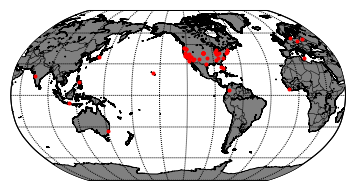

In [13]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation, rc
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

lons = []
lats = []

fig, ax = plt.subplots()
# 'f' for full resolution, kinda slow
world_map = Basemap(projection='robin', resolution = 'h', area_thresh = 1000.0,
              lat_0=0, lon_0=-130)
world_map.drawcoastlines()
world_map.drawcountries()
world_map.fillcontinents(color = 'gray')
world_map.drawmapboundary()
world_map.drawmeridians(np.arange(0, 360, 30))
world_map.drawparallels(np.arange(-90, 90, 30))

x,y = world_map(0, 0)
point = world_map.plot(x, y, 'ro', markersize=3)[0]

def init():
    point.set_data([], [])
    return point,
def animate(i):
    if i < len(tweets_df):
        lons.append(tweets_df.iloc[i]['long-lat'][0])
        lats.append(tweets_df.iloc[i]['long-lat'][1])
        x, y = world_map(lons, lats)
        point.set_data(x, y)
    return point,

anim = animation.FuncAnimation(plt.gcf(), animate, init_func=init,
                               frames=len(tweets_df), interval=200, blit=True)
HTML(anim.to_html5_video())


In [ ]:
# would've liked to use tweepy's streaming features to livestream retweets